In [5]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct


saveFigs = False

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData
from mpmath import *

from Decon import SpectralDecon
from Interpolation_Class import Interpolation


mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'


In [2]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
coreNames = CoresSpecs['CoreName']
site = 'SiteA'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]

dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
bdot0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']+273.15
dens0 = CoreSpecs['dens0']
z0 = CoreSpecs['z0']


DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
N_InInt = 32

SiteA


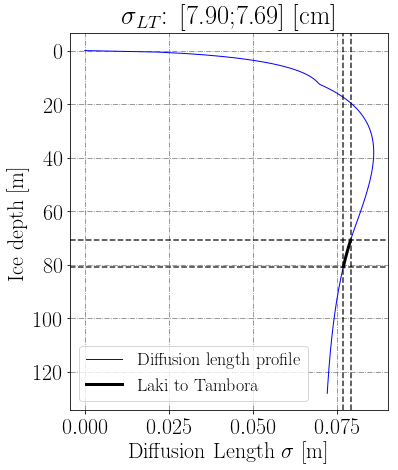

In [17]:

sigmas = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + site + '_DepthDiff.txt','\t')
sigma_arr = sigmas['sigma_o18']
z_vec = sigmas['Depth']


TambDepth = dTamb
LakiDepth = dLaki
z_LT = z_vec[(z_vec >= TambDepth) & (z_vec <= LakiDepth)]
sigma_LT = np.asarray(sigma_arr[(z_vec >= TambDepth) & (z_vec <= LakiDepth)])




figDiff, axDiff= plt.subplots(figsize=(6,7))

axDiff.invert_yaxis()
axDiff.plot(sigma_arr,z_vec, 'b', lw=1, label = 'Diffusion length profile')
axDiff.plot(sigma_LT,z_LT, 'k', lw=3, label='Laki to Tambora')
axDiff.axhline(y = TambDepth, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axhline(y = LakiDepth, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_LT[0], alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_LT[-1], alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.set(xlabel='Diffusion Length $\sigma$ [m]', ylabel='Ice depth [m]',title='$\sigma_{LT}$' +f': [{sigma_LT[0]*100:.2f};{sigma_LT[-1]*100:.2f}] [cm]')
axDiff.grid(True, color='grey',ls='-.')
axDiff.legend(fontsize=18)
figDiff.tight_layout()
print(site)

[(60.95, 90.85)]

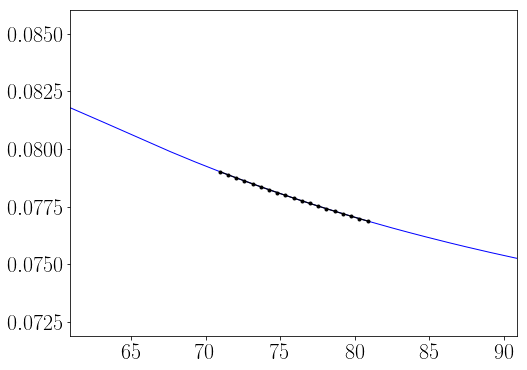

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(z_vec,sigma_arr, 'b', lw=1)
ax.plot(z_LT,sigma_LT, color='k', lw=1.2, marker='.')
ax.set(ylim=(min(sigma_LT)-0.005, max(sigma_LT)+0.007))
ax.set(xlim=(min(z_LT)-10,max(z_LT)+10))

In [8]:
data = np.asarray(d18O_LT) - np.mean(np.asarray(d18O_LT))
depth = np.asarray(depth_LT)
N = 2000

inst = SpectralDecon(depth, data, N, 'NDCT')

In [9]:
x,y = inst.deconvolve2(z_LT, sigma_LT)

In [18]:
xC, yC = inst.deconvolve(np.mean(sigma_LT))

In [19]:
peaksC = sp.signal.find_peaks(yC)[0]
peaksZ = sp.signal.find_peaks(y)[0]

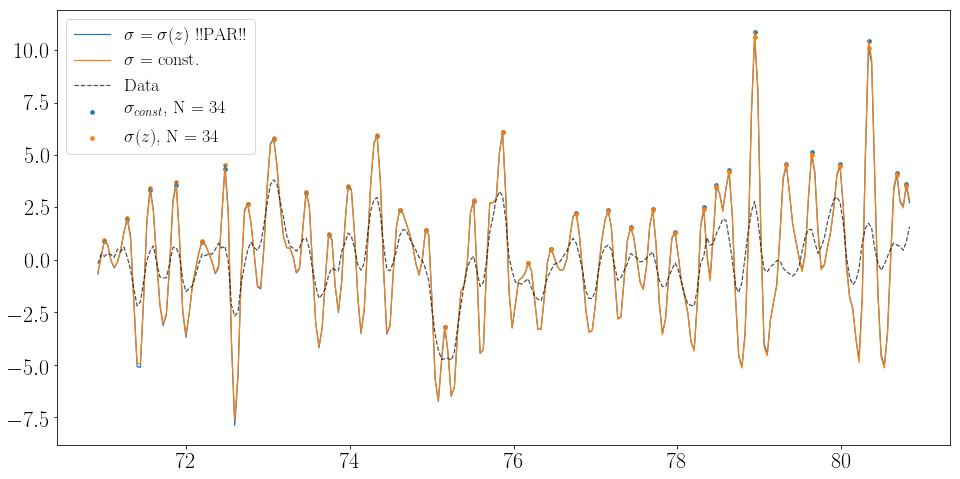

In [20]:

fig, ax = plt.subplots(figsize=(16,8))
mpl.rcParams['font.size'] = 22
plt.plot(x,y, lw=1.2, label=f'$\sigma = \sigma(z)$ !!PAR!!', ls='-')
plt.plot(xC,yC, lw=1.2, label=f'$\sigma$ = const.', ls='-')
plt.plot(depth, data,lw=1.2, label='Data', ls='--', C='k', alpha=0.7)
plt.scatter(xC[peaksC],yC[peaksC], lw=1.2, label='$\sigma_{const}$'+f', N = {len(peaksC)}',s=12)
plt.scatter(x[peaksZ],y[peaksZ], lw=1.2, label='$\sigma(z)$'+f', N = {len(peaksZ)}', s=12)

plt.legend(fontsize=18)



In [18]:


#start_time = time.time()
#
#dataBD = np.zeros_like(data)
#depthBD = np.zeros_like(depth)
#
#for i in range(len(data)):
#    if i%10==0:
#        print(i)
#    dataBD[i], depthBD[i] = funcDecon(idx=i)
#print("--- %s seconds ---" % (time.time() - start_time))

In [6]:


# Define data under examination
x_arr = z_LT
y_arr = sigma_LT

# Define objective function 
def fct(x,a,b,c):
    return a*(x**2) + b*x + c

# Fit curve to data
from scipy.optimize import curve_fit
popt, test = curve_fit(fct, x_arr, y_arr)

a, b, c = popt


In [7]:
residuals = y_arr - fct(x_arr,*popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_arr - np.mean(y_arr))**2)
r2 = 1 - (ss_res / ss_tot)
r2

0.9999988870472794

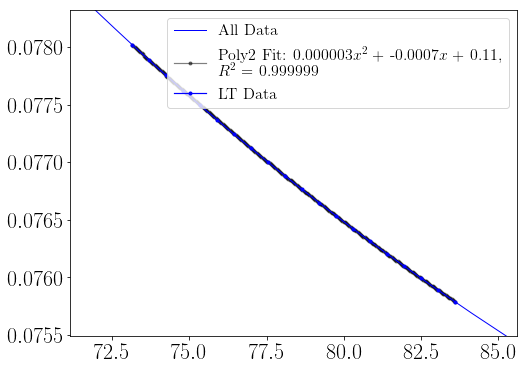

In [64]:
Npoints = len(d18O_LT)#2200-1
delta = (max(z_LT) - min(z_LT))/Npoints
xTest = np.arange(min(z_LT),max(z_LT)+delta,delta)
yTest = fct(xTest, a, b, c)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(z_vec,sigma_arr, 'b', lw=1, label='All Data')
ax.plot(xTest,yTest, color='k', lw=1.2, marker='.', alpha=0.5,label=f'Poly2 Fit: {a:.6f}$x^2$ + {b:.4f}$x$ + {c:.2f}, \n$R^2$ = {r2:.6f}')
ax.plot(z_LT,sigma_LT, color='b', lw=1.2, marker='.', label='LT Data')
ax.set(ylim=(min(sigma_LT)-0.0003, max(sigma_LT)+0.0003),xlim=(min(z_LT)-2, max(z_LT)+2))
ax.legend(fontsize=16)

In [76]:
z_arr = xTest
sig_arr = yTest

expo = -z_arr**2/(2*sig_arr**2)

#from mpmath import *
mp.dps=10

test_mpf = [exp(x) for x in expo]
sumtest = sum(test_mpf)
test_mpfN = [x/(sumtest) for x in test_mpf]
#test2 = test/sum(test)

